In [1]:
#Import libraries
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive/')




Mounted at /content/drive/


In [3]:
path = '/content/drive/MyDrive/Colab Datasets/Daily Bike Sharing.csv'

In [4]:
#Importing data
data = pd.read_csv(path,index_col = "dteday", parse_dates = True)


In [5]:
#Select appropriate variables
dataset = data.loc[:, ["cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.head(5)                       

,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


In [6]:
#Rename the dependent variable
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset.head(5)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


In [7]:
#Modify index to daily frequency
dataset = dataset.asfreq("D")
dataset.index

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
               '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
               '2012-12-30', '2012-12-31'],
              dtype='datetime64[ns]', name='dteday', length=731, freq='D')

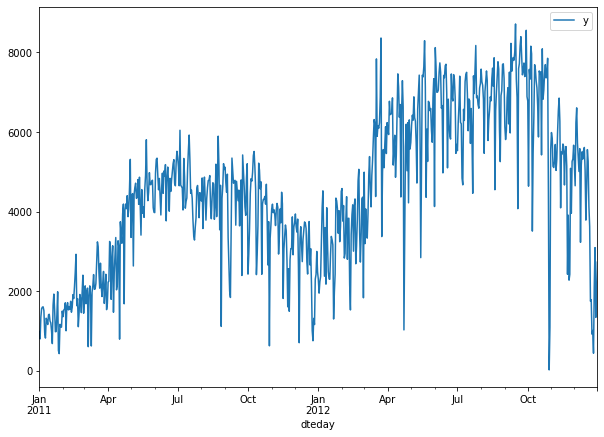

In [8]:
#Visualisation of the data
dataset["y"].plot(figsize = (10, 7), legend = True)

In [9]:
#Split the data into training set and test set

test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail(2)

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2012-12-30,1796,0,0,1,0.255833,0.231700,0.483333,0.350754
2012-12-31,2729,0,1,2,0.215833,0.223487,0.577500,0.154846


In [10]:
#Import special library
import tensorflow_probability as tfp

In [11]:
#Isolate the regressors
exog = dataset.iloc[:,1:]
exog.head()

,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,
2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900


In [12]:
#We need to give the result the shape of a matrix and ensure the numbers are float and not int
exog = np.asmatrix(dataset.iloc[:,1:].astype(np.float64))
exog[:1]

matrix([[0.      , 0.      , 2.      , 0.344167, 0.363625, 0.805833,
         0.160446]])

In [ ]:
#Building the Linear Regression model

In [13]:
regressors = tfp.sts.LinearRegression(design_matrix = exog, name = 'regressors')

In [14]:
#Focus on the seasonality --> we isolate the dependent variable
y = training_set['y'].astype(np.float64)
y[:5]


dteday
2011-01-01     985.0
2011-01-02     801.0
2011-01-03    1349.0
2011-01-04    1562.0
2011-01-05    1600.0
Freq: D, Name: y, dtype: float64

In [15]:
#Weekly seasonality
weekday_effect = tfp.sts.Seasonal(num_seasons = 7, # 7 days in a week
                                  num_steps_per_season = 1, #daily data then 1, if it was hourly data it would be 24
                                  observed_time_series = y,#the dependent variavle
                                  name = "weekday_effect")

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [16]:
#Monthly seasonality
num_days_per_month = np.array(
    [[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], #2011
     [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]]) # 2012

In [17]:
#Monthly seasonality
monthly_effect = tfp.sts.Seasonal(num_seasons = 12, #12 months a year
                                  num_steps_per_season = num_days_per_month,# we described in previous step
                                  observed_time_series = y,
                                  name = "monthly_effect")

In [18]:
#Trend components and Auto Regressive

#Trends
trend = tfp.sts.LocalLinearTrend(observed_time_series=y,
                                 name = "trend")


In [19]:
#Auto Regressive
autoregressive = tfp.sts.Autoregressive(order = 1,#lagged. Start with 1 and then change it if needed 
                                        observed_time_series = y,
                                        name = "autoregressive")

In [20]:
#Tensorflow Structural Time Series
#Forecasting model
model = tfp.sts.Sum([regressors,#components are in brackets
                     weekday_effect,
                     monthly_effect,
                     autoregressive,
                     trend],
                    observed_time_series = y)

In [21]:
#Fit the model with HMC
samples, kernel_results = tfp.sts.fit_with_hmc(model = model,
                                               observed_time_series = y,
                                               num_results = 100,
                                               num_warmup_steps = 50,
                                               num_leapfrog_steps = 15,
                                               num_variational_steps = 150,
                                               seed = 1502)

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [22]:
#Forecasting
forecast = tfp.sts.forecast(model = model,
                            observed_time_series = y,
                            parameter_samples = samples,
                            num_steps_forecast = len(test_set))

In [24]:
#Predictions
forecast.mean()

<tf.Tensor: shape=(31, 1), dtype=float64, numpy=
array([[4210.88870137],
       [3463.17097189],
       [4391.65302653],
       [4466.98728982],
       [4626.41400701],
       [4608.76228869],
       [3780.89595007],
       [3708.18880956],
       [3129.95173983],
       [3311.53406664],
       [3409.84791765],
       [3578.14903421],
       [4373.04302091],
       [4354.77209101],
       [4282.67644529],
       [2896.22719093],
       [3077.81028968],
       [3984.922636  ],
       [4153.01501636],
       [3331.01190755],
       [3312.6912096 ],
       [4048.63293086],
       [3470.88616716],
       [2843.7005693 ],
       [2939.96600276],
       [2301.72770509],
       [3096.78650737],
       [3079.01906837],
       [3006.53110339],
       [3237.04221234],
       [2610.13944844]])>

In [26]:
#We need to create a frame for these results
pd.Series(forecast.mean()[:,0], name = "TFP") 


0     4210.888701
1     3463.170972
2     4391.653027
3     4466.987290
4     4626.414007
5     4608.762289
6     3780.895950
7     3708.188810
8     3129.951740
9     3311.534067
10    3409.847918
11    3578.149034
12    4373.043021
13    4354.772091
14    4282.676445
15    2896.227191
16    3077.810290
17    3984.922636
18    4153.015016
19    3331.011908
20    3312.691210
21    4048.632931
22    3470.886167
23    2843.700569
24    2939.966003
25    2301.727705
26    3096.786507
27    3079.019068
28    3006.531103
29    3237.042212
30    2610.139448
Name: TFP, dtype: float64

In [27]:
#We save these predictions giving it a frame
#predictions
predictions_tfp = pd.Series(forecast.mean()[:,0], name = "TFP")
predictions_tfp.index = test_set.index
predictions_tfp[:2]

dteday
2012-12-01    4210.888701
2012-12-02    3463.170972
Freq: D, Name: TFP, dtype: float64

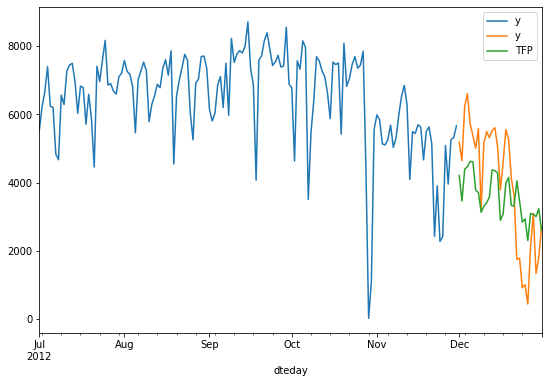

In [28]:
#Visualisation
training_set['y']['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set['y'].plot(legend = True)
predictions_tfp.plot(legend = True)

In [29]:
#MAPE to assess the model
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_tfp)

58.14698229735821